In [1]:
import nibabel as nib
import numpy as np

import sys
sys.path.append("/opt/wbplot")

from wbplot import dscalar

from IPython.display import Image

from pathlib import Path
from collections import defaultdict
from functools import lru_cache

Get HCP info
- `hcp_mappings`: dict of ROI: dscalars
- `hcp_rois`: 

In [2]:
"""Get HCP labels
"""
dlabel_dir = Path("/opt/app/notebooks/data/dlabels")
hcp_label = dlabel_dir / "Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii"

_HCP_INFO = !wb_command -file-information {hcp_label}
HCP_LABELS = []
HCP_COUNTER = 0
for i in _HCP_INFO:
    if len(i) == 60 and any(["L_" in i, "R_" in i]):
        hcp_colors = tuple([float(f"0.{k}") for k in [j.split(' ') [0] for j in i.split('0.')][-3:]] + [1])
        if ' R_' in i:
            roi = i.split("_ROI")[0].split(' R_')[1]
            HCP_LABELS.append(f"R_{roi}_ROI")
        if ' L_' in i:
            roi = i.split("_ROI")[0].split(' L_')[1]
            HCP_LABELS.append(f"L_{roi}_ROI")
        HCP_COUNTER += 1

"""Get HCP label coordinates
"""
dscalar_dir = Path("/opt/app/notebooks/data/dscalars")
tmpdir = Path("/tmp")
template_dscalar = dscalar_dir / "S1200.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii"

hcp_mapping = {}
for roi_label in HCP_LABELS:
    out_dscalar = tmpdir / f"{roi_label}.dscalar.nii"
    if out_dscalar.exists():
        hcp_mapping[roi_label] = out_dscalar
        continue
    !wb_command -cifti-label-to-roi {hcp_label} {out_dscalar} -name {roi_label}
    assert out_dscalar.exists(), f"{out_dscalar.stem} does not exist."
    hcp_mapping[roi_label] = out_dscalar
hcp_rois = list(set([k.split('_')[1] for k in hcp_mapping.keys()]))

Functions

In [ ]:
def convert_to_fractional_overlap(data):

    return data.sum(0) / data.shape[0]

def map_data_to_value(data_list):

    for ix, (k,v) in enumerate(data_list):

        if ix == 0:
            new_data = k.copy() * v
        else:
            new_data += k * v

    return new_data

def combine_f1_f2(f1,f2,fo=1.,mask=None, f1_c=.01, f2_c=.82, f1f2_c=.28, mask_c=.01):
    f1_data = convert_to_fractional_overlap(nib.load(f1).get_fdata())
    f2_data = convert_to_fractional_overlap(nib.load(f2).get_fdata())

    f1_data = (f1_data >= fo).astype(int)
    f2_data = (f2_data >= fo).astype(int)
    f1f2_data = ((f1_data + f2_data) == 2).astype(int)
    f1_data -= f1f2_data
    f2_data -= f1f2_data

    if mask:
        mask_data = convert_to_fractional_overlap(nib.load(mask).get_fdata())
        mask_data = (mask_data >= 1.).astype(int)
        mask_data -= f1f2_data
        mask_data -= f1_data
        mask_data -= f2_data

    #data_dict = [(f1_data, .01), (f2_data, .82), (f1f2_data, .28)]
    data_dict = [(f1_data, f1_c), (f2_data, f2_c), (f1f2_data, f1f2_c)]
    if mask:
        data_dict.append((mask_data,mask_c))

    return map_data_to_value(data_dict)

def get_quadrant_id(mask_path):
    rel_mask_path = mask_path.split("/")[-1]
    idx_start = rel_mask_path.find("Q")
    quadrant_id = rel_mask_path[idx_start:idx_start+2]
    assert quadrant_id in ['Q1', 'Q2'], f"{quadrant_id} not Q1 or Q2"

    return quadrant_id

def merge_and_binarize_mask(data, f1_c, f2_c, f1f2_c, mask_c):

    new_data = data.copy()
    new_data[(new_data == f1_c) | (new_data == f2_c) | (new_data == f1f2_c)] = 1
    new_data[new_data == mask_c] = 0

    return new_data

@lru_cache(maxsize=360)
def read_roi_path(roi_path):
    return nib.load(roi_path).get_fdata()[0,:]

def roi_vertex_counter(
    roi_vertex_count,
    hcp_mapping,
    data,
    q_id,
):

    for roi_label, roi_path in hcp_mapping.items():
        if q_id == "Q1":
            contra = "L_"
        elif q_id == "Q2":
            contra = "R_"
        else:
            raise ValueError(f"{q_id} not supported.")

        if roi_label.startswith(contra):
            roi_label = f"CONTRA_{roi_label[2:-4]}"
        else:
            roi_label = f"IPSI_{roi_label[2:-4]}"

        roi_mask = read_roi_path(roi_path)
        assert roi_mask.shape == data.shape
        
        roi_vertex_count[roi_label].append((roi_mask * data).sum())

    return roi_vertex_count

def condense_roi_info_across_cohort(sub_ids, roi_vertex_count, sub_threshold=.5):
    
    n_sub_per_roi = []

    n_sub_total = len(sub_ids)
    for roi, vertex_count_across_subs in roi_vertex_count.items():
        n_sub_per_roi.append(
            (
                roi, # ROI label
                sum([i>0 for i in vertex_count_across_subs])/n_sub_total, # Number of subjects with vertex in a ROI
                np.median(vertex_count_across_subs), # Median vertex count
            )
        )

    my_list = [i[2] for i in n_sub_per_roi]
    sorted_indices = sorted(range(len(my_list)), key=lambda x: my_list[x], reverse=True)
    
    condensed_roi_info = []
    for i in sorted_indices:
        if n_sub_per_roi[i][1]<sub_threshold:
            continue
        condensed_roi_info.append(n_sub_per_roi[i])

    return condensed_roi_info

def find_activations(experiment_id, mri_id, roi_task_id, roi_f_1, fo, sub_id, match_str="activations.dtseries.nii"):
    
    import os

    directory = f"/scratch/fastfmri/experiment-{experiment_id}_mri-{mri_id}_smooth-0_truncate-39-219_n-200_batch-merged_desc-basic_roi-{roi_task_id}-{roi_f_1}_fo-{fo}_bootstrap/sub-{sub_id}/bootstrap/"
    activations_files = [file for file in os.listdir(directory) if 'data-train' in file and match_str in file]

    return [f"{directory}{i}" for i in activations_files]

def set_base_dir(basedir):
    basedir = Path(basedir)
    if not basedir.exists():
        basedir.mkdir(exist_ok=True, parents=True)

    return basedir

def generate_single_subject_maps(
    label, experiment_id, mri_id, sub_ids, 
    roi_task_ids, roi_f_1s, roi_f_2s, 
    ROI_FO=.8, SUB_THRESHOLD=.5,
    LEFT=600, TOP=120, RIGHT=1120, BOTTOM=420,
):

    roi_vertex_count = defaultdict(list)

    for ix, (sub_id, roi_task_id, roi_f_1, roi_f_2) in enumerate(zip(
        sub_ids,
        roi_task_ids, 
        roi_f_1s,
        roi_f_2s,
    )):

        png_out = Path(set_base_dir(f"./ComputeCanada/frequency_tagging/figures/dual_frequency_mapping")) / f"label-{label}_mri-{mri_id}_sub-{sub_id}_task-{roi_task_id}_f-{roi_f_1}-{roi_f_2}.fo-{ROI_FO}.png"
        if png_out.exists():
            #continue
            pass

        VERTEX_TO = 59412
        f1 = find_activations(experiment_id, mri_id, roi_task_id, roi_f_1, .8, sub_id, match_str="activations.dtseries.nii")
        f2 = find_activations(experiment_id, mri_id, roi_task_id, roi_f_2, .8, sub_id, match_str="activations.dtseries.nii")
        mask = find_activations(experiment_id, mri_id, roi_task_id, roi_f_1, .8, sub_id, match_str="mask.dtseries.nii")
        for f in [f1,f2, mask]:
            assert len(f) == 1

        f1, f2 = f1[0], f2[0]
        data = combine_f1_f2(f1, f2, fo=ROI_FO, mask=mask[0], f1_c=f1_c,f2_c=f2_c,f1f2_c=f1f2_c,mask_c=mask_c)
        data = data[:VERTEX_TO]

        map_data = merge_and_binarize_mask(data,f1_c,f2_c,f1f2_c,mask_c)
        q_id = get_quadrant_id(mask[0])
        roi_vertex_count = roi_vertex_counter(roi_vertex_count, hcp_mapping, map_data, q_id)
        
        palette_params = {
            "disp-zero": False,
            "disp-neg": True,
            "disp-pos": True,
            "pos-user": (0, 1.),
            "neg-user": (-1,0),
            "interpolate": True,
        }
        dscalar(
            png_out, data, 
            orientation="portrait", 
            hemisphere='right',
            palette=PALETTE, 
            palette_params=palette_params,
            transparent=False,
            flatmap=True,
            flatmap_style='plain',
        )
        
        crop_and_save(png_out, str(png_out).replace("png", "cropped.png"), LEFT, TOP, RIGHT, BOTTOM)

    roi_cohort_info = condense_roi_info_across_cohort(
        sub_ids, 
        roi_vertex_count, 
        sub_threshold=SUB_THRESHOLD
    )

    return roi_cohort_info


def load_mean_power_dtseries(dtseries):
    mean_power = nib.load(dtseries).get_fdata().mean(0)
    return mean_power

def crop_and_save(input_file, output_file, left, top, right, bottom):
    from PIL import Image
    try:
        # Open the input image
        with Image.open(input_file) as img:
            # Crop the image
            cropped_img = img.crop((left, top, right, bottom))
            # Save the cropped image
            cropped_img.save(output_file)
            print("Cropped image saved successfully as", output_file)
    except Exception as e:
        print("An error occurred:", e)

Save visualizations
- 3T normal (.125/.2)
- 7T normal (.125/.2)
- 3T varying frequencies
- 7T varying frequencies

In [ ]:
"""Set up for visualizing dual frequency tagging across each subject using fractional overlap
"""
PALETTE = "power_surf"
f1_c = -.1 # red -.1
f2_c = .82 # blue .82
f1f2_c = .88 # white .88 yellow .14
mask_c = .41 # .9 [green], .1 [goldish], .4 [black]

cohort_roi_info_across_experiments = {}
ROI_FOS = [.4,.6,.8,1.]

"""Save png
"""
# 3T normal
label = "3TNormal"
cohort_roi_info = defaultdict(list)
for ROI_FO in ROI_FOS:
    experiment_id = "1_frequency_tagging" 
    mri_id = "3T"
    sub_ids = ["000", "002", "003", "004", "005", "006", "007", "008", "009"] 
    roi_task_ids = ["entrain"] * len(sub_ids)
    roi_f_1s = [.125] * len(sub_ids)
    roi_f_2s = [.2] * len(sub_ids)
    cohort_roi_info[ROI_FO] = generate_single_subject_maps(
        label, experiment_id, mri_id, sub_ids, 
        roi_task_ids, roi_f_1s, roi_f_2s, 
        ROI_FO=ROI_FO, SUB_THRESHOLD=.5
    )
cohort_roi_info_across_experiments[label] = cohort_roi_info
# 7T normal
label = "7TNormal"
cohort_roi_info = defaultdict(list)
for ROI_FO in ROI_FOS:
    experiment_id = "1_attention" 
    mri_id = "7T"
    sub_ids = ["Pilot001", "Pilot009", "Pilot010", "Pilot011"]
    roi_task_ids = ["AttendAway"] * len(sub_ids)
    roi_f_1s = [.125] * len(sub_ids)
    roi_f_2s = [.2] * len(sub_ids)
    cohort_roi_info[ROI_FO] = generate_single_subject_maps(
        label, experiment_id, mri_id, sub_ids, 
        roi_task_ids, roi_f_1s, roi_f_2s, 
        ROI_FO=ROI_FO, SUB_THRESHOLD=.5
    )
cohort_roi_info_across_experiments[label] = cohort_roi_info
# 3T vary
label = "3TVary"
cohort_roi_info = defaultdict(list)
for ROI_FO in ROI_FOS:
    experiment_id = "1_frequency_tagging"
    mri_id = "3T"
    sub_ids = ["020"] * 3 + ["021"] * 3
    roi_task_ids = [f"entrain{i}" for i in ["A", "B", "C", "D", "E", "F"]]
    roi_f_1s = [.125] * 3 + [.125, .15, .175]
    roi_f_2s = [.2, .175, .15] + [.2] * 3
    cohort_roi_info[ROI_FO] = generate_single_subject_maps(
        label, experiment_id, mri_id, sub_ids, 
        roi_task_ids, roi_f_1s, roi_f_2s, 
        ROI_FO=ROI_FO, SUB_THRESHOLD=.5
    )
cohort_roi_info_across_experiments[label] = cohort_roi_info
# 7T vary
label = "7TVary"
cohort_roi_info = defaultdict(list)
for ROI_FO in ROI_FOS:
    experiment_id = "1_frequency_tagging"
    mri_id = "7T"
    sub_ids = ["020"] * 3 + ["021"] * 3
    roi_task_ids = [f"entrain{i}" for i in ["A", "B", "C", "D", "E", "F"]]
    roi_f_1s = [.125] * 3 + [.125, .15, .175]
    roi_f_2s = [.2, .175, .15] + [.2] * 3
    cohort_roi_info[ROI_FO] = generate_single_subject_maps(
        label, experiment_id, mri_id, sub_ids, 
        roi_task_ids, roi_f_1s, roi_f_2s, 
        ROI_FO=ROI_FO, SUB_THRESHOLD=.5
    )
cohort_roi_info_across_experiments[label] = cohort_roi_info

In [ ]:
show_top_x = 20
for i in ["3TNormal", "7TNormal", "3TVary", "7TVary"]:
    print('\n',i)
    for j_ix, j in enumerate(cohort_roi_info_across_experiments[i][.2][:show_top_x]):
        print(j_ix+1, j)

In [ ]:
sub_id = "020"
task_id = "entrainA"
power_f = .125

png = Path(f"/tmp/{sub_id}.{task_id}.power-f-{power_f}.png")
assert png.exists()
print(png)
Image(png)

In [ ]:
sub_id = "020"
task_id = "entrainA"
power_f = .125

png = Path(f"/tmp/{sub_id}.{task_id}.power-f-{power_f}.png")
assert png.exists()
print(png)
Image(png)

Plot power across ROIs

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
import itertools

def read_pickle(pkl):

    import pickle 
    
    with open(pkl, 'rb') as f:
        data = pickle.load(f)

    return data

def read_statistics(observed_statistics, n_bootstraps):

    accuracy = sum([i[0] < .05 for i in observed_statistics]) / n_bootstraps

    observed_statistics = np.array([i[1] for i in observed_statistics])
    mean_statistic = np.mean(observed_statistics)
    confidence_interval = np.percentile(observed_statistics, [2.5, 97.5])

    return {
        "accuracy": accuracy,
        "mean": mean_statistic, 
        "CI": confidence_interval,
    }

In [45]:
from copy import copy 

def plot_power_of_rois_across_cohort(
    experiment_id, 
    mri_id, 
    sub_ids, 
    roi_task_ids, 
    roi_fs, 
    primary_fs, 
    secondary_fs, 
    task_ids, 
    fo, 
    n_permutations,n_bootstraps,
    JITTER=.25,
    FONTSIZE=4,
    FIGSIZE=(5,2),
    NORMAL_EXPERIMENTS=True,
):

    all_fs = list(set(roi_fs))
    all_fs.sort()

    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=FIGSIZE, dpi=200)

    for row_ix, control_roi_size in enumerate([True, False]):
        for col_ix, phaseadjusted in enumerate([True, False]):

            f_mapping = {
                "primary_frequency": axs[row_ix, col_ix], 
                "secondary_frequency": axs[row_ix, col_ix], 
                "im_frequency": axs[row_ix, col_ix],
            }

            primary_mean_across_cohort = defaultdict(list)
            primary_frequency_across_cohort = defaultdict(list)
            for sub_id, roi_task_id, roi_f, primary_f, secondary_f, task_id in zip(
                sub_ids, roi_task_ids, roi_fs, primary_fs, secondary_fs, task_ids
            ):
                if control_roi_size and primary_f < secondary_f:
                    pkl = Path(f"/scratch/fastfmri/pickles/experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roitask-{roi_task_id}_roi-{roi_f}_controlroisizetomatch-{secondary_f}_task-{task_id}_fo-{fo}_phaseadjusted-{phaseadjusted}_n-{n_permutations}.pkl")
                else:
                    pkl = Path(f"/scratch/fastfmri/pickles/experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roitask-{roi_task_id}_roi-{roi_f}_task-{task_id}_fo-{fo}_phaseadjusted-{phaseadjusted}_n-{n_permutations}.pkl")
                #print(f"[{row_ix}, {col_ix}] {pkl}")
                #print(f"ROI-{roi_task_id}-{roi_f}, probing [{primary_f}/{secondary_f}]")
                assert pkl.exists(), f"{pkl} does not exist."

                pkl_data = read_pickle(pkl)

                plot_x = []
                plot_y = []
                for k, v in pkl_data.items():
                    #print(k, f"test-{round(secondary_f-primary_f, 10)}")
                    marker = "o"
                    mec = 'k'
                    ms=4
                    zorder=10
                    if k == f"test-{primary_f}":
                        label = "primary_frequency"
                    elif k == f"test-{secondary_f}":
                        label = "secondary_frequency"
                    elif k == f"test-{abs(round(secondary_f-primary_f, 10))}":
                        label = "im_frequency"
                    else:
                        raise ValueError(f"{k} does not match {primary_f} or {secondary_f}")
                        
                    ax = f_mapping[label]

                    frequency = float(k.split("test-")[-1])
                    
                    statistic_info = read_statistics(v, n_bootstraps)
                    if label == "primary_frequency":
                        primary_mean_across_cohort[sub_id].append(statistic_info['mean'])
                        if frequency == min(all_fs):
                            primary_frequency_across_cohort[sub_id].append(frequency+JITTER)
                        if frequency == max(all_fs):
                            primary_frequency_across_cohort[sub_id].append(frequency-JITTER)

                    _accuracy = statistic_info['accuracy']
                    if sub_id == "000":
                        print(pkl)
                        print(f"[x] sub-{sub_id}_roi-{roi_task_id}-{roi_f}_task-{task_id}_mainf-{primary_f}_secf-{secondary_f}_{label}, acc: {_accuracy*100:.1f}%")

                    if _accuracy == 1:
                        mfc = 'r'
                        zorder+=2
                    elif _accuracy < 1. and _accuracy >= .8:
                        mfc = 'gold'
                        zorder+=1
                    else:
                        mfc = 'grey'

                    offset=0
                    s=10
                    if label == 'secondary_frequency':
                        continue # temporarily remove
                        offset+=.003
                        ms = 2
                        zorder=5

                    jitter = np.random.uniform(low=-JITTER, high=JITTER)
                    ax.errorbar(
                        frequency+offset+jitter, statistic_info['mean'], yerr=statistic_info['CI'][:,np.newaxis], 
                        marker=marker, ms=ms, c='k', 
                        markeredgewidth=.5, markerfacecolor=mfc, markeredgecolor=mec,
                        lw=.5, capsize=2, capthick=1, zorder=zorder
                    )
                    #ax.text(frequency+offset+jitter+.003, statistic_info['mean'], roi_task_id, fontsize=FONTSIZE)

                    plot_x.append(frequency)
                    plot_y.append(statistic_info['mean'])

                #xfrequency_with_jitter = copy(plot_x)
                #xfrequency_with_jitter.sort()
                #xfrequency_with_jitter[0] += JITTER
                #xfrequency_with_jitter[1] -= JITTER
                #ax.plot(plot_x, plot_y, linestyle=':', lw=1, c='lightgrey', zorder=2)

            """CONNECT LINES SAME SUBJECTS
            """
            if NORMAL_EXPERIMENTS:
                for sub_id in primary_frequency_across_cohort.keys():
                    ax.plot(
                        primary_frequency_across_cohort[sub_id], primary_mean_across_cohort[sub_id], linestyle=':', lw=1, c='lightgrey', zorder=2
                    )
            ax.set_ylabel("PSD", fontsize=FONTSIZE)
            ax.set_xlabel("Frequency", fontsize=FONTSIZE)
            ax.set_title(f"Phaseadjusted-{phaseadjusted} controlsize-{control_roi_size}", fontsize=FONTSIZE)

            fig.suptitle(f"{mri_id} / ROI: f1/f2 / {fo}", fontsize=FONTSIZE)
            fig.tight_layout()

    max_vals = []
    for row_ix, col_ix in itertools.product(range(2), range(2)):
        vals = axs[row_ix,col_ix].get_ylim()
        max_vals.append(vals[-1])
    max_ylim = max(max_vals)

    for row_ix, col_ix in itertools.product(range(2), range(2)):
        axs[row_ix,col_ix].set_ylim(-.0001, max_ylim)
        axs[row_ix,col_ix].set_xticks(all_fs)
        axs[row_ix,col_ix].set_xticklabels([str(i) for i in all_fs], fontsize=FONTSIZE)
        axs[row_ix,col_ix].set_yticklabels(
            axs[row_ix,col_ix].get_yticklabels(), 
            fontsize=FONTSIZE
        )
        axs[row_ix,col_ix].spines['top'].set_visible(False)
        axs[row_ix,col_ix].spines['right'].set_visible(False)
        axs[row_ix,col_ix].spines['bottom'].set_visible(False)
        axs[row_ix,col_ix].spines['left'].set_visible(False)
        axs[row_ix,col_ix].tick_params(axis='x', length=0.) 
        axs[row_ix,col_ix].tick_params(axis='y', length=0.)
        for _f in all_fs:
            axs[row_ix,col_ix].axvspan(
                _f-JITTER-.0015, _f+JITTER+.0015, 
                facecolor='lightgray', alpha=0.5
            )

def plot_power_of_rois_across_cohort_intersection(
    experiment_id, 
    mri_id, 
    sub_ids, 
    roi_task_ids, 
    roi_fs, 
    primary_fs, 
    secondary_fs, 
    task_ids, 
    fo, 
    n_permutations,n_bootstraps,
    JITTER=.25,
    FONTSIZE=4,
    FIGSIZE=(5,2),
    NORMAL_EXPERIMENTS=True,
):

    all_fs = list(set(roi_fs))
    all_fs.sort()

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=FIGSIZE, dpi=200)

    for col_ix, phaseadjusted in enumerate([True, False]):

        f_mapping = {
            "primary_frequency": axs[col_ix], 
            "secondary_frequency": axs[col_ix], 
            "im_frequency": axs[col_ix],
        }

        primary_mean_across_cohort = defaultdict(list)
        primary_frequency_across_cohort = defaultdict(list)
        for sub_id, roi_task_id, roi_f, primary_f, secondary_f, task_id in zip(
            sub_ids, roi_task_ids, roi_fs, primary_fs, secondary_fs, task_ids
        ):
            if secondary_f > roi_f:
                pkl = Path(f"/scratch/fastfmri/pickles/experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roitask-{roi_task_id}_roi-{roi_f}-{secondary_f}_task-{task_id}_fo-{fo}_phaseadjusted-{phaseadjusted}_n-{n_permutations}.pkl")
            else:
                pkl = Path(f"/scratch/fastfmri/pickles/experiment-{experiment_id}_mri-{mri_id}_sub-{sub_id}_roitask-{roi_task_id}_roi-{secondary_f}-{roi_f}_task-{task_id}_fo-{fo}_phaseadjusted-{phaseadjusted}_n-{n_permutations}.pkl")
            if not pkl.exists():
                print(f"Warning: {pkl} does not exist. Probably means intersection doesn't exist.\nSkipping")
                continue

            pkl_data = read_pickle(pkl)
            #print(pkl, pkl_data.keys())

            plot_x = []
            plot_y = []
            for k, v in pkl_data.items():
                marker = "o"
                mec = 'k'
                ms=4
                zorder=10
                if k == f"test-{primary_f}":
                    label = "primary_frequency"
                elif k == f"test-{secondary_f}":
                    label = "secondary_frequency"
                elif k == f"test-{abs(round(secondary_f-primary_f, 10))}":
                    label = "im_frequency"
                else:
                    raise ValueError(f"{k} does not match {primary_f} or {secondary_f}")
                if label == "secondary_frequency":
                    continue
                    
                ax = f_mapping[label]

                frequency = float(k.split("test-")[-1])
                
                statistic_info = read_statistics(v, n_bootstraps)
                if label == "primary_frequency":
                    primary_mean_across_cohort[sub_id].append(statistic_info['mean'])
                    if frequency == min(all_fs):
                        primary_frequency_across_cohort[sub_id].append(frequency+JITTER)
                    if frequency == max(all_fs):
                        primary_frequency_across_cohort[sub_id].append(frequency-JITTER)

                _accuracy = statistic_info['accuracy']
                if sub_id == "000":
                    print(pkl)
                    print(f"[I] sub-{sub_id}_roi-{roi_task_id}-{roi_f}_task-{task_id}_mainf-{primary_f}_secf-{secondary_f}_{label}, acc: {_accuracy*100:.1f}%")

                if _accuracy == 1:
                    mfc = 'r'
                    zorder+=2
                elif _accuracy < 1. and _accuracy >= .8:
                    mfc = 'gold'
                    zorder+=1
                else:
                    mfc = 'grey'

                offset=0
                s=10
                jitter = np.random.uniform(low=-JITTER, high=JITTER)
                ax.errorbar(
                    frequency+offset+jitter, statistic_info['mean'], yerr=statistic_info['CI'][:,np.newaxis], 
                    marker=marker, ms=ms, c='k', 
                    markeredgewidth=.5, markerfacecolor=mfc, markeredgecolor=mec,
                    lw=.5, capsize=2, capthick=1, zorder=zorder
                )

                plot_x.append(frequency)
                plot_y.append(statistic_info['mean'])

        """CONNECT LINES SAME SUBJECTS
        """
        if NORMAL_EXPERIMENTS:
            for sub_id in primary_frequency_across_cohort.keys():
                ax.plot(
                    primary_frequency_across_cohort[sub_id], primary_mean_across_cohort[sub_id], linestyle=':', lw=1, c='lightgrey', zorder=2
                )
        ax.set_ylabel("PSD", fontsize=FONTSIZE)
        ax.set_xlabel("Frequency", fontsize=FONTSIZE)
        ax.set_title(f"Phaseadjusted-{phaseadjusted}", fontsize=FONTSIZE)

        fig.suptitle(f"{mri_id} / ROI: Intersection / {fo}", fontsize=FONTSIZE)
        fig.tight_layout()

    max_vals = []
    for col_ix in range(2):
        vals = axs[col_ix].get_ylim()
        max_vals.append(vals[-1])
    max_ylim = max(max_vals)

    for col_ix in range(2):
        axs[col_ix].set_ylim(-.0001, max_ylim)
        axs[col_ix].set_xticks(all_fs)
        axs[col_ix].set_xticklabels([str(i) for i in all_fs], fontsize=FONTSIZE)
        axs[col_ix].set_yticklabels(
            axs[col_ix].get_yticklabels(), 
            fontsize=FONTSIZE
        )
        axs[col_ix].spines['top'].set_visible(False)
        axs[col_ix].spines['right'].set_visible(False)
        axs[col_ix].spines['bottom'].set_visible(False)
        axs[col_ix].spines['left'].set_visible(False)
        axs[col_ix].tick_params(axis='x', length=0.) 
        axs[col_ix].tick_params(axis='y', length=0.)
        for _f in all_fs:
            axs[col_ix].axvspan(
                _f-JITTER-.0015, _f+JITTER+.0015, 
                facecolor='lightgray', alpha=0.5
            )

In [46]:
FONTSIZE=4
FIGSIZE_F1F2=(4,3)
FIGSIZE_INTERSECTION=(4,1.5)

import warnings

# To ignore the specific warning
warnings.filterwarnings("ignore")

3T normal

/scratch/fastfmri/pickles/experiment-1_frequency_tagging_mri-3T_sub-000_roitask-entrain_roi-0.125_controlroisizetomatch-0.2_task-entrain_fo-0.4_phaseadjusted-True_n-1000.pkl
[x] sub-000_roi-entrain-0.125_task-entrain_mainf-0.125_secf-0.2_primary_frequency, acc: 100.0%
/scratch/fastfmri/pickles/experiment-1_frequency_tagging_mri-3T_sub-000_roitask-entrain_roi-0.125_controlroisizetomatch-0.2_task-entrain_fo-0.4_phaseadjusted-True_n-1000.pkl
[x] sub-000_roi-entrain-0.125_task-entrain_mainf-0.125_secf-0.2_secondary_frequency, acc: 100.0%
/scratch/fastfmri/pickles/experiment-1_frequency_tagging_mri-3T_sub-000_roitask-entrain_roi-0.125_controlroisizetomatch-0.2_task-entrain_fo-0.4_phaseadjusted-True_n-1000.pkl
[x] sub-000_roi-entrain-0.125_task-entrain_mainf-0.125_secf-0.2_im_frequency, acc: 100.0%
/scratch/fastfmri/pickles/experiment-1_frequency_tagging_mri-3T_sub-000_roitask-entrain_roi-0.2_task-entrain_fo-0.4_phaseadjusted-True_n-1000.pkl
[x] sub-000_roi-entrain-0.2_task-entrain_mainf-0.2

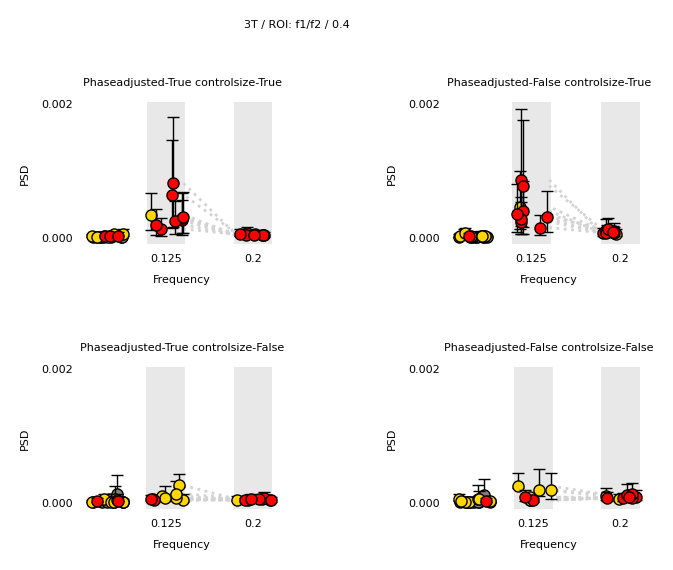

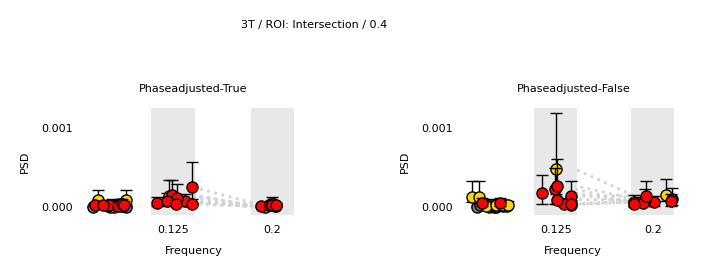

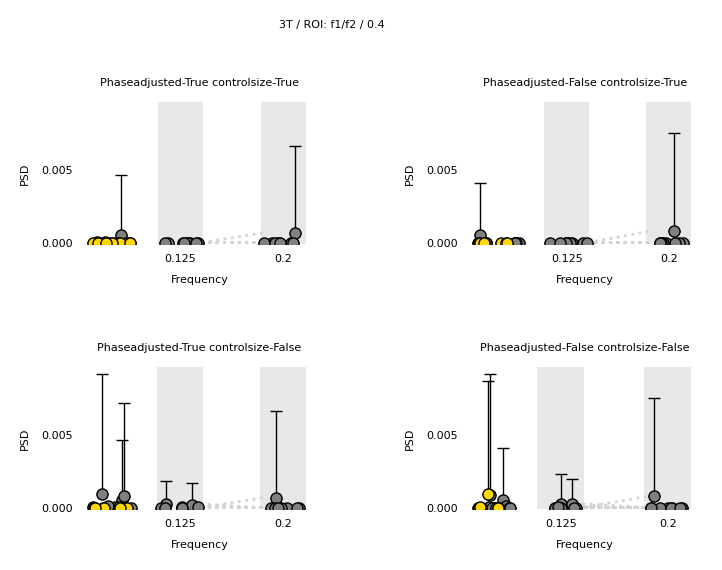

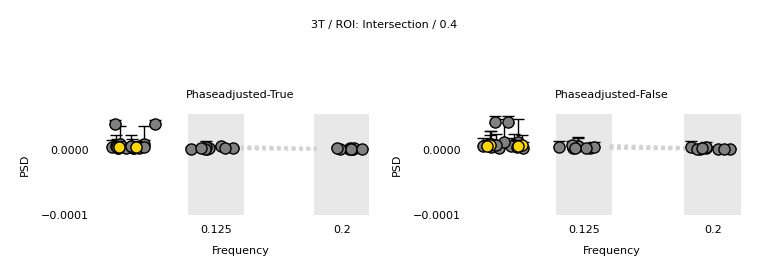

In [47]:
NORMAL_3T_SUB_IDS = ["000", "002", "003", "004", "005", "006", "007", "008", "009"]

for _task_id in ["entrain", "control"]:
    experiment_id = "1_frequency_tagging"
    mri_id = "3T"
    sub_ids = NORMAL_3T_SUB_IDS * 2
    roi_task_ids = ["entrain"] * 2 * len(NORMAL_3T_SUB_IDS)
    roi_fs = [.125, .2] * len(NORMAL_3T_SUB_IDS)
    primary_fs = [.125, .2] * len(NORMAL_3T_SUB_IDS)
    secondary_fs = [.2, .125] * len(NORMAL_3T_SUB_IDS)
    task_ids = [_task_id] * 2 * len(NORMAL_3T_SUB_IDS)
    n_permutations = 1000
    n_bootstraps = 200
    for fo in [.4]:
        for plot_func, FIGSIZE in zip(
            [plot_power_of_rois_across_cohort, plot_power_of_rois_across_cohort_intersection], 
            [FIGSIZE_F1F2, FIGSIZE_INTERSECTION]
        ):

            plot_func(
                experiment_id, 
                mri_id, 
                sub_ids, 
                roi_task_ids, 
                roi_fs, 
                primary_fs, 
                secondary_fs, 
                task_ids, 
                fo, 
                n_permutations,
                n_bootstraps,
                JITTER=.015,
                FONTSIZE=FONTSIZE,
                FIGSIZE=FIGSIZE,
            )

7T normal

In [ ]:
NORMAL_7T_SUB_IDS = ["Pilot001", "Pilot009", "Pilot010", "Pilot011"]

experiment_id = "1_attention"
mri_id = "7T"
sub_ids = NORMAL_7T_SUB_IDS * 2
roi_task_ids = ["AttendAway"] * 2 * len(NORMAL_7T_SUB_IDS)
roi_fs = [.125] * 4 + [.2] * 4
primary_fs = [.125] * 4 + [.2] * 4
secondary_fs = [.2] * 4 + [.125] * 4
task_ids = ["AttendAway"] * 2 * len(NORMAL_7T_SUB_IDS)
fo = .8
n_permutations = 1000
n_bootstraps = 200

for plot_func, FIGSIZE in zip(
    [plot_power_of_rois_across_cohort, plot_power_of_rois_across_cohort_intersection], 
    [FIGSIZE_F1F2, FIGSIZE_INTERSECTION]
):
    plot_func(
        experiment_id, 
        mri_id, 
        sub_ids, 
        roi_task_ids, 
        roi_fs, 
        primary_fs, 
        secondary_fs, 
        task_ids, 
        fo, 
        n_permutations,
        n_bootstraps,
        JITTER=.015,
        FONTSIZE=FONTSIZE,
        FIGSIZE=FIGSIZE,
    )

sub-020, vary 3T/7T

In [ ]:
experiment_id = "1_frequency_tagging"
mri_ids = ["3T","7T"]
sub_ids = ["020"] * 6
roi_task_ids = ["entrainA", "entrainB", "entrainC"] * 2
roi_fs = [.125, .125, .125, .2, .175, .15]
primary_fs = [.125, .125, .125, .2, .175, .15]
secondary_fs = [.2, .175, .15, .125, .125, .125]
task_ids = ["entrainA", "entrainB", "entrainC"] * 2
fo = .8
n_permutations = 1000
n_bootstraps = 200

for plot_func, FIGSIZE in zip(
    [plot_power_of_rois_across_cohort, plot_power_of_rois_across_cohort_intersection], 
    [FIGSIZE_F1F2, FIGSIZE_INTERSECTION]
):
    for mri_id in mri_ids:
        plot_func(
            experiment_id, 
            mri_id, 
            sub_ids, 
            roi_task_ids, 
            roi_fs, 
            primary_fs, 
            secondary_fs, 
            task_ids, 
            fo, 
            n_permutations,
            n_bootstraps,
            JITTER=.005,
            FONTSIZE=FONTSIZE,
            FIGSIZE=FIGSIZE,
            NORMAL_EXPERIMENTS=False,
        )

sub-021, vary 3T/7T

In [ ]:
experiment_id = "1_frequency_tagging"
mri_ids = ["3T","7T"]
sub_ids = ["021"] * 6
roi_task_ids = ["entrainD", "entrainE", "entrainF"] * 2
roi_fs = [.125, .15, .175, .2, .2, .2]
primary_fs = [.125, .15, .175, .2, .2, .2]
secondary_fs = [.2, .2, .2, .125, .15, .175]
task_ids = ["entrainD", "entrainE", "entrainF"] * 2
fo = .8
n_permutations = 1000
n_bootstraps = 200

for plot_func, FIGSIZE in zip(
    [plot_power_of_rois_across_cohort, plot_power_of_rois_across_cohort_intersection], 
    [FIGSIZE_F1F2, FIGSIZE_INTERSECTION]
):
    for mri_id in mri_ids:
        plot_func(
            experiment_id, 
            mri_id, 
            sub_ids, 
            roi_task_ids, 
            roi_fs, 
            primary_fs, 
            secondary_fs, 
            task_ids, 
            fo, 
            n_permutations,
            n_bootstraps,
            JITTER=.005,
            FONTSIZE=FONTSIZE,
            FIGSIZE=FIGSIZE,
            NORMAL_EXPERIMENTS=False,
        )